# Project 1: Linear Quadratic Regulator (LQR) Design
>**Date Created**: 26 January 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [875]:
import control as ct
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp

from numpy import sin, cos
from matplotlib import pyplot as plt

# Problem Description
___

### Dynamical System

In many instances for spacecraft dynamics and control, one is interested in modeling the dynamics
between multiple spacecraft, e.g., a **rendezvous and proximity operation (RPO)**. To that end,
consider the following simplified model of two satellites operating in proximity, i.e. a simplified
**three-body problem**, involving a **chaser spacecraft** and a **target spacecraft** (subscript $t$) on
an elliptical orbit. One can represent this relative motion in the **Hill frame (HF)** for the target
spacecraft as shown in the following figure.

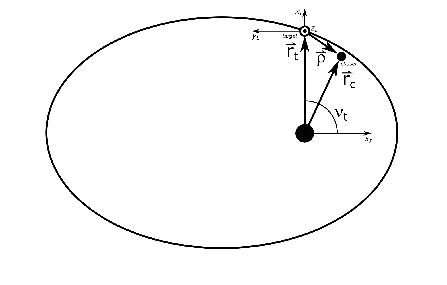

Thus, one can represent the target position relative to the celestial body in the target’s HF axes
as $$\vec{r}_t = \begin{bmatrix} r_t \\ 0 \\ 0 \end{bmatrix}$$

and the relative position of the chaser in the target's HF axes as $$\vec{\rho} = \begin{bmatrix} x \\ y \\ z\end{bmatrix}$$

Then, noting $$\vec{r}_c = \vec{r}_t + \vec{\rho}$$ 

## Problem 1

Compute the eigenvalues of the state matrix for the continuous LTI system and comment on the stability of the system.

In [876]:
mu = 3.986004418 * 10**14
rt = 6783000
x0 = np.array([1000, 1000, 1000, 0, 0, 0])
nt = np.sqrt(mu / (rt**3))
ti = 0
tf = 16200
n = 25000
t_eval = np.linspace(ti, tf, n)

In [877]:
A_ct_numpy = np.array(
    [
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [3 * nt**2, 0, 0, 0, 2 * nt, 0],
        [0, 0, 0, -2 * nt**2, 0, 0],
        [0, 0, -(nt**2), 0, 0, 0],
    ]
)
B_ct_numpy = np.array(
    [
     [0, 0, 0],
     [0, 0, 0], 
     [0, 0, 0], 
     [1, 0, 0], 
     [0, 1, 0], 
     [0, 0, 1]
    ]
)
e = np.linalg.eig(A_ct_numpy)

**Problem Response**

> $r_t$ will never be less than zero, and $\mu$ is a constant greter than zero, so $n_t$ will always be greater than zero. For $n_t \geq 0.75$, the eigenvalues of the dynamics matrix are purely imaginary and thus the system is **marginally stable**, that is, the system will have bounded oscillations with no control input. 

## Problem 2
Compute the controllability matrix for the continuous-time LTI system.

In [878]:
ctrb = ct.ctrb(A_ct_numpy, B_ct_numpy)
print(np.linalg.matrix_rank(ctrb))

6


**Problem Response**

> System is controllable since the controllability matrix is full rank.

## Problem 3

Design a finite-horizon LQR for the continuous time system with $t_f = 16200 s$ using ODE solvers.

In [879]:
# Defone functions to be passed into ODE solvers 

def dPdt(t, P, A, B, Q, R):
    P = P.reshape((6, 6))
    dpdt = (
        -np.dot(P, A)
        - np.dot(A.T, P)
        + np.dot(P, B).dot(np.linalg.inv(R)).dot(B.T).dot(P)
        - Q
    ).flatten()
    return dpdt


def dxdt(t, x, A, B, R, P, ts):
    interp_P = sp.interpolate.interp1d(ts, P.reshape(6,6,-1))
    P_t = interp_P(t).reshape((6, 6))
    K_t = np.linalg.inv(R) @ B.T @ P_t 
    u = -K_t @ x 
    xdot = (A - B @ K_t) @ x
    return xdot


def calc_u(Ps, A, R, B, t_solve):
    u_s = np.zeros((3, t_solve.shape[0]))
    interp_P = sp.interpolate.interp1d(t_solve, Ps.reshape(36, -1))
    for k, t in enumerate(t_solve):
        if k == 0:
            x = np.array([1000, 1000, 1000, 0, 0 ,0])
        else:
            x = x_c
        P_t = interp_P(t).reshape((6, 6))
        K_t = np.linalg.inv(R) @ B.T @ P_t
        u = -K_t @ x
        x = A @ x + B @ u
        x_c = x 
        u_s[:, k] = u
    return u_s

In [916]:
# Case 1
sols_P_case1 = sp.integrate.solve_ivp(
    fun=dPdt,
    t_span=[16200, 0],
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), np.eye(3)),
)


# Flip time series and P so we can use it to solve for \vec{x} from [0,tf]
t_solve_case1 = np.flip(sols_P_case1.t)
P_case1 = np.flip(sols_P_case1.y.reshape((6, 6, -1)))

sols_cl_case1 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case1,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, np.eye(3), P_case1, t_solve_case1),
)




In [926]:
a = calc_u(P_case1, A_ct_numpy, np.eye(3), B_ct_numpy, (t_eval))

ValueError: x and y arrays must be equal in length along interpolation axis.

(0.0, 60.0)

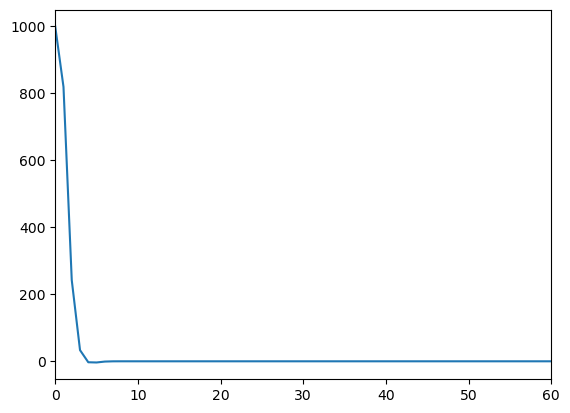

In [925]:
plt.plot(sols_cl_case1.y[0,:])
plt.xlim([0,60])

In [883]:
# Case 2

sols_P_case2 = sp.integrate.solve_ivp(
    dPdt,
    t_span=[16200, 0],
    t_eval=np.flip(t_eval),
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), 100 * np.eye(3)),
)
t_solve_case2 = np.flip(sols_P_case2.t)
P_case2 = np.flip(sols_P_case2.y.reshape((6, 6, -1)))
sols_cl_case2 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case2,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, 100 * np.eye(3), P_case2, t_solve_case2),
)

In [884]:
# Case 3

sols_P_case3 = sp.integrate.solve_ivp(
    dPdt,
    t_span=[16200, 0],
    t_eval=np.flip(t_eval),
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), 10000 * np.eye(3)),
)
t_solve_case3 = np.flip(sols_P_case3.t)
P_case3 = np.flip(sols_P_case3.y.reshape((6, 6, -1)))
sols_cl_case3 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case3,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, 10000 * np.eye(3), P_case3, t_solve_case3),
)

(0.0, 60.0)

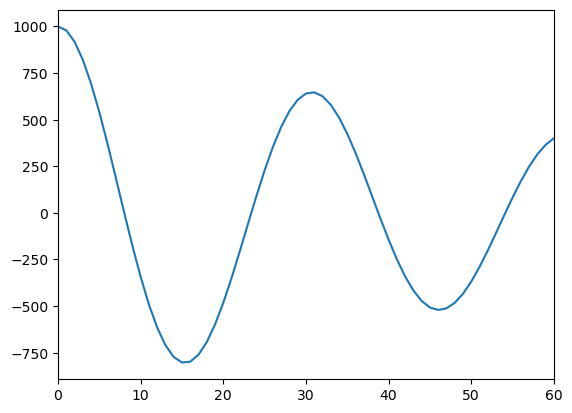

In [912]:
plt.plot(sols_cl_case2.y[0,:])
plt.xlim([0, 60])

### Problem 4

Design a finite-horizon LQR for the continuous time system with $t_f = 16200 s$ using a continuous-time algebraic Riccati equation solver.

In [499]:
A = np.array([[0,0,0,1,0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1],
             [3*nt**2, 0, 0, 0, 2*nt, 0],
             [0,0,0,-2*nt,0,0],
             [0,0,-nt**2,0,0,0]])
B = np.array([[0,0,0],
             [0,0,0],
             [0,0,0],
             [1,0,0],
             [0,1,0],
             [0,0,1]])

In [500]:
def dxdt_care(t, x, A, B, P, R):
    K_t = np.linalg.inv(R) @ B.T @ P
    xdot = (A - B @ K_t) @ x
    return xdot

def calc_u_care(t_eval, A, B, R, P):
    u_s = np.zeros((3, t_eval.shape[0]))  # array to hold output commands, u
    K_t = np.linalg.inv(R) @ B.T @ P # Optimal gain calculation
    
    # Compute dynamics and optimal control input, u at each value of t in the series
    for k, t in enumerate(t_eval):
        if k == 0:
            x = x0
        else:
            x = x_c
        u = - K_t @ x
        u_s[:,k] = u
        xdot = A @ x + B @ u
        x = x + xdot
        x_c = x
    return u_s

In [501]:
# Case 1 
Q = np.eye(6)
R = np.eye(3)
P_case1_care = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case1_care = sp.integrate.solve_ivp(fun=dxdt_care, t_span=[ti, tf], t_eval=t_eval, y0=x0, args=(A, B, P_case1_care, R))
u_case1_care = calc_u_care(t_eval, A_ct_numpy, B_ct_numpy, R, P_case1_care) 

# Case 2
Q = np.eye(6)
R = 100*np.eye(3)
P_care_case2 = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case2_care = sp.integrate.solve_ivp(fun=dxdt_care, t_span=[ti, tf],t_eval=t_eval, y0=x0, args=(A, B, P_care_case2, R))
case2_care = calc_u_care(t_eval, A_ct_numpy, B_ct_numpy, R, P_care_case2) 

# Case 3
Q = np.eye(6)
R = 10000*np.eye(3)
P_care_case3 = sp.linalg.solve_continuous_are(A_ct_numpy, B_ct_numpy, Q, R)
sol_case3_care = sp.integrate.solve_ivp(fun=dxdt_care, t_span=[ti, tf], t_eval=t_eval, y0=x0, args=(A, B_ct_numpy, P_care_case3, R))
u_case3_care = calc_u_care(t_eval, A_ct_numpy, B, R, P_care_case3) 


In [502]:
def plot_u(u_s, title='Case 1'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10),sharex=True,sharey=True)
    ax1.plot(t_eval, u_s[0,:])
    ax1.set_xlim([0, 40])
    ax1.set_title('$u_x$')
    ax2.plot(t_eval, u_s[1,:])
    ax2.set_xlim([0, 40])
    ax2.set_title('$u_y$')
    ax3.plot(t_eval, u_s[2,:])
    ax3.set_xlim([0, 40])
    ax3.set_title('$u_z$')
    fig.supxlabel('Time (sec)')
    fig.supylabel('Commanded Acceleration ($m/s^2$)')
    fig.suptitle(title,fontsize='x-large')
    

In [506]:
def plot_xy(sols, title='Case 1'):
    fig, ax  = plt.subplots()
    ax.plot(sols.y[0,:],sols.y[1,:])
    ax.set_title(title, fontsize='x-large')
    ax.set_xlabel('x (meters)')
    ax.set_ylabel('y (meters)')    

In [508]:
def plot_z(t_eval, sols, title='Case 1'):
    fig, ax  = plt.subplots()
    ax.plot(t_eval, sols.y[2,:])
    ax.set_title(title, fontsize='x-large')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('z (meters)')   

### Problem 5

Design a finite-horizon LQR for the discrete-time LTI system approximation with $\Delta t = 1s$ and $N = 1500$.

In [825]:
# Define dynamics and constants
P0 = np.zeros((6,6))
N = 1500
dt = 1
F = lambda nt, dt: np.array([[4-3*cos(nt*dt), 0, 0, nt**(-1)*sin(nt*dt), 2*nt**(-1)*(1-cos(nt*dt)), 0],
                            [6*(sin(nt*dt)-nt*dt), 1, 0, -2*nt**(-1)*(1-cos(nt*dt)), nt**(-1)*(4*sin(nt*dt)-3*nt*dt), 0],
                            [0, 0, cos(nt*dt), 0,0, nt**(-1)*sin(nt*dt)],
                            [3*nt*sin(nt*dt), 0, 0, cos(nt*dt), 2*sin(nt*dt), 0],
                            [-6*nt*(1-cos(nt*dt)), 0, 0, -2*sin(nt*dt), 4*cos(nt*dt) - 3, 0],
                            [0, 0, -nt*sin(dt*dt), 0, 0, cos(nt*dt)]])
G = lambda nt, dt: F(nt, dt)[:,3:]

In [828]:
# Define functions to solve discrete-time Riccati Equation and Closed Loop Dynamics

def recursive_solve_are(N, dt, nt, F, G, Q, R, P0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    Ps = np.zeros((6,6,N))
    
    for k in range(N):
        if k == 0:
            P = P0
            Ps[:,:,k] = P
            continue
        else:
            Pkm1 = F_k.T @ P @ F_k + Q - (F_k.T @ P @ G_k) @ np.linalg.inv(G_k.T @ P @ G_k + R) @ (G_k.T @ P @ F_k)
            Ps[:,:, k] = Pkm1
            P = Pkm1
    return Ps

def solve_recursive_cl(N, dt, nt, F, G, Ps, Q, R, x0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    xd = np.zeros((6,N))
    u_s = np.zeros((3,N))
    for k in range(N):
        if k == 0:
            x = x0
            xkp1 = x0
            K = np.linalg.inv((G_k.T @ Ps[:,:, 0] @ G_k + R)) @ (G_k.T @ Ps[:,:, 0] @ F_k)
            u = -K @ x
        elif k < N-1:
            K = np.linalg.inv((G_k.T @ Ps[:,:, k + 1] @ G_k + R)) @ (G_k.T @ Ps[:,:, k + 1] @ F_k)
            u = -K @ x
            xkp1 = (F_k - G_k @ K) @ x
        else:
            K = np.linalg.inv((G_k.T @ Ps[:,:, k] @ G_k + R)) @ (G_k.T @ Ps[:,:, k] @ F_k)
            u = -K @ x
            xkp1 = (F_k - G_k @ K) @ x
        xd[:, k] = xkp1
        u_s[:,k] = u
        x = xkp1
    return xd, us

In [829]:
# Case 1
Q = np.eye(6)
R = np.eye(3)

P_case1_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case1_discrete, u_case1_discrete = solve_recursive_cl(N, dt, nt, F, G, P_case1_discrete, Q, R, x0)

# Case 2
Q = np.eye(6)
R = 100*np.eye(3)

P_case2_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case2_discrete, u_case2_discrete = solve_recursive_cl(N, dt, nt, F, G, P_case2_discrete, Q, R, x0)

# Case 3
Q = np.eye(6)
R = 10000*np.eye(3)

P_case3_discrete = recursive_solve_are(N, dt, nt, F, G, Q, R, P0)
sol_case3_discrete, u_case3_discrete = solve_recursive_cl(N, dt, nt, F, G, P_case3_discrete, Q, R, x0)

### Problem 6

In [830]:
def solve_recursive_cl_constant_P(N, dt, nt, F, G, P, Q, R, x0):
    F_k = F(nt, dt)
    G_k = G(nt, dt)
    K_k = np.linalg.inv(G_k.T @ P @ G_k + R) @ G_k.T @ P @ F_k
    
    xd = np.zeros((6,N))
    u_s = np.zeros((3,N))
    
    for k in range(N):
        if k == 0:
            x = x0
            xd[:, k] = x
            u_s[:,k] = -K_k @ x
        else:
            xkp1 = (F_k - G_k @ K_k) @ x
            u = -K_k @ x
            xd[:, k] = xkp1
            u_s[:, k] = u
            x = xkp1
    return xd, u_s
            

In [831]:
# Case 1
Q = np.eye(6)
R = np.eye(3)
P_dare_case1 = sp.linalg.solve_discrete_are(F(nt,dt), G(nt,dt), Q, R)
sol_dare_case1, u_dare_case1 = solve_recursive_cl_constant_P(N, dt, nt, F, G, P_dare_case1, Q, R, x0)

# Case 2
Q = np.eye(6)
R = 100*np.eye(3)
P_dare_case2 = sp.linalg.solve_discrete_are(F(nt,dt), G(nt,dt), Q, R)
sol_dare_case2, u_dare_case2 = solve_recursive_cl_constant_P(N, dt, nt, F, G, P_dare_case2, Q, R, x0)

# Case 3
Q = np.eye(6)
R = 10000*np.eye(3)
P_dare_case3 = sp.linalg.solve_discrete_are(F(nt,dt), G(nt,dt), Q, R)
sol_dare_case3, u_dare_case3 = solve_recursive_cl_constant_P(N, dt, nt, F, G, P_dare_case3, Q, R, x0)